# **Machine Learning on Big Data (CN7030) CRWK 24-25 Term B [60% weighting]**
# **Group ID: Group_T23**

# 1. Student 1: Name and ID
# 2. Student 2: Name and ID  
# 3. Student 3: Name and ID
# If you want to add comments on your group work, please write it here for us:


# **Initiate and Configure Spark**

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, explode, array, lit, create_map
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from functools import reduce

# ✅ Initialize Spark session with optimized configuration for speed
spark = SparkSession.builder \
    .appName("CN7030 Text Classification - Complete Implementation") \
    .master("local[*]") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "6g") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "4g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.default.parallelism", "8") \
    .getOrCreate()

print("✅ Optimized Spark session initialized successfully")

✅ Optimized Spark session initialized successfully


---
# **Task 1 - Data Loading and Preprocessing (15 marks)**
---

In [3]:
## Student 1: Muhammad Jahanzaib Ali Khan - Data Loading and Basic Preprocessing

# Load the dataset
df = spark.read.format("csv") \
    .option("header", True) \
    .option("multiLine", True) \
    .option("quote", '"') \
    .option("escape", '"') \
    .option("inferSchema", True) \
    .option("mode", "PERMISSIVE") \
    .load("complaints-2025-08-06_16_14(1).csv")

print("Dataset loaded successfully.")
print(f"Total rows: {df.count()}, Total columns: {len(df.columns)}")
df.show(5, truncate=50)

Dataset loaded successfully.
Total rows: 278884, Total columns: 18
+-------------+--------------------------------------------------+----------------+--------------------------------------------------+---------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------+-----+--------+----+--------------------------+-------------+--------------------+-------------------------------+----------------+------------------+------------+
|Date received|                                           Product|     Sub-product|                                             Issue|                                    Sub-issue|                      Consumer complaint narrative|                           Company public response|                               Company|State|ZIP code|Tags|Consumer consent provided?|Submitted via|Date sent to company|   Company response to consumer|Timely respon

In [4]:
# Select relevant columns and handle missing values
df_clean = df.select("Product", "Consumer complaint narrative")
rows_before = df_clean.count()
df_clean = df_clean.dropna(subset=["Product", "Consumer complaint narrative"])
rows_after = df_clean.count()

print(f"Rows before dropping nulls: {rows_before}")
print(f"Rows after dropping nulls: {rows_after} ({(rows_before - rows_after)/rows_before*100:.2f}% removed)")

Rows before dropping nulls: 278884
Rows after dropping nulls: 267991 (3.91% removed)


In [5]:
# Encode string labels to numerical labels
indexer = StringIndexer(inputCol="Product", outputCol="label")
indexer_model = indexer.fit(df_clean)
df_encoded = indexer_model.transform(df_clean)

print("\nLabels encoded successfully.")
df_encoded.select("Product", "label").show(5, truncate=False)


Labels encoded successfully.
+---------------------------------------------------+-----+
|Product                                            |label|
+---------------------------------------------------+-----+
|Credit reporting or other personal consumer reports|0.0  |
|Credit reporting or other personal consumer reports|0.0  |
|Credit reporting or other personal consumer reports|0.0  |
|Credit reporting or other personal consumer reports|0.0  |
|Credit reporting or other personal consumer reports|0.0  |
+---------------------------------------------------+-----+
only showing top 5 rows


In [6]:
# Check class distribution
class_counts = df_encoded.groupBy("label").count().orderBy("count", ascending=False).toPandas()
print("\nClass Distribution:")
print(class_counts)


Class Distribution:
   label   count
0    0.0  220366
1    1.0   23434
2    2.0    9264
3    3.0    8892
4    4.0    3329
5    5.0    2706


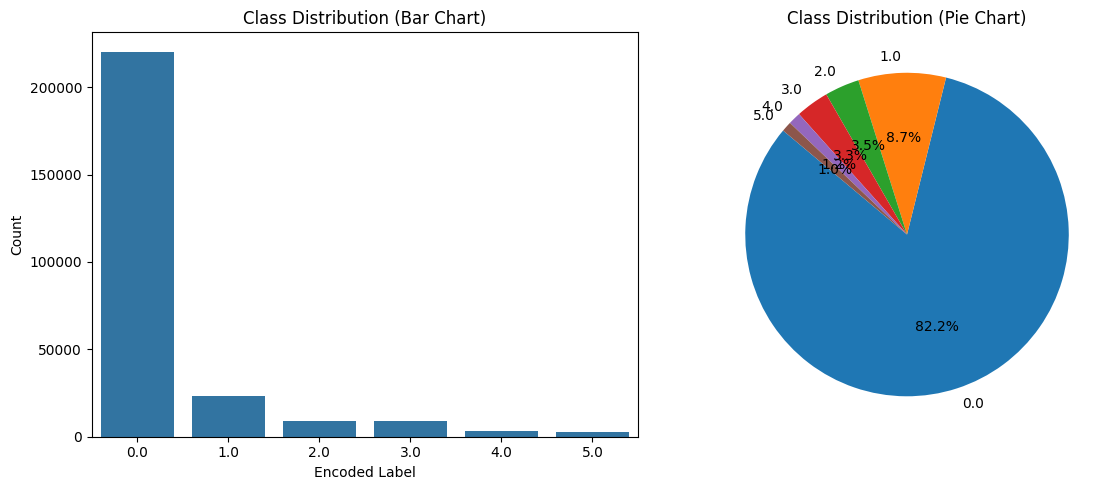

In [7]:
# Visualize class distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x="label", y="count", data=class_counts)
plt.title("Class Distribution (Bar Chart)")
plt.xlabel("Encoded Label")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.pie(class_counts['count'], labels=class_counts['label'], autopct='%1.1f%%', startangle=140)
plt.title("Class Distribution (Pie Chart)")
plt.tight_layout()
plt.show()

In [8]:
# Split data into train and test sets (70-30 split)
train_df, test_df = df_encoded.randomSplit([0.7, 0.3], seed=42)
print(f"\nData split complete. Train rows: {train_df.count()}, Test rows: {test_df.count()}")


Data split complete. Train rows: 187440, Test rows: 80551


In [9]:
# Optimization function for dataframes
def optimize_dataframe(df, target_partitions=8, cache=True):
    """Function to repartition and cache a DataFrame for better performance."""
    print(f"Optimizing dataframe with {target_partitions} partitions...")
    df_optimized = df.repartition(target_partitions)
    if cache:
        df_optimized.cache()
        count = df_optimized.count()  # Trigger caching
        print(f"Dataframe optimized and cached with {count} rows.")
    return df_optimized

# Apply optimizations
train_df_opt = optimize_dataframe(train_df, target_partitions=8)
test_df_opt = optimize_dataframe(test_df, target_partitions=4)

Optimizing dataframe with 8 partitions...
Dataframe optimized and cached with 187440 rows.
Optimizing dataframe with 4 partitions...
Dataframe optimized and cached with 80551 rows.



=== OVERSAMPLING STRATEGY IMPLEMENTATION ===
Major class count: 153962.0
Oversampling complete. Training rows before: 187440, Training rows after: 909310
Optimizing dataframe with 8 partitions...
Dataframe optimized and cached with 909310 rows.


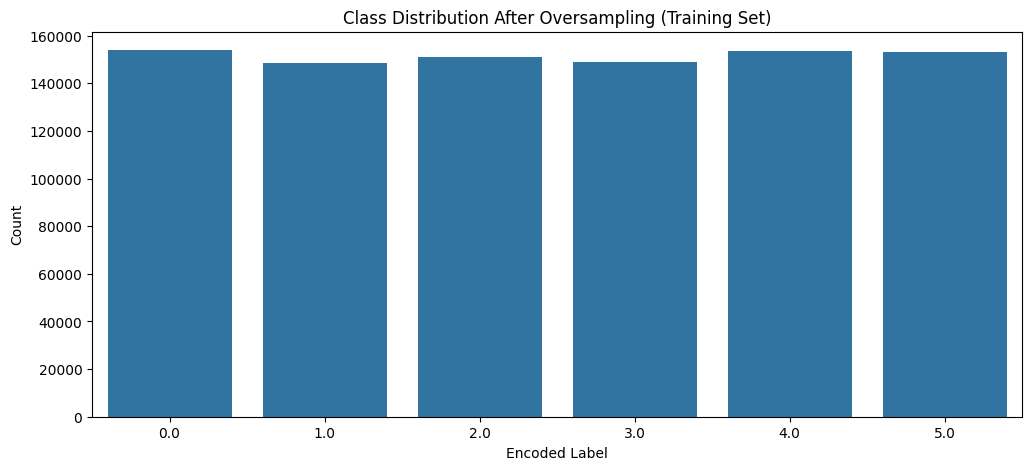

In [10]:
print("\n=== OVERSAMPLING STRATEGY IMPLEMENTATION ===")

# Calculate oversampling ratios
train_class_counts = train_df_opt.groupBy("label").count().orderBy("count", ascending=False).toPandas()
major_class_count = train_class_counts.iloc[0]['count']
print(f"Major class count: {major_class_count}")

# Full oversampling to balance all classes
ratios = train_df_opt.groupBy("label").count().withColumn("ratio", major_class_count / col("count")).select("label", "ratio").collect()

oversampled_train_df = train_df_opt
for row in ratios:
    label = row["label"]
    ratio = int(row["ratio"])
    if ratio > 1:
        minority_df = train_df_opt.filter(col("label") == label)
        # Duplicate minority class rows
        for i in range(ratio - 1):
            oversampled_train_df = oversampled_train_df.unionAll(minority_df)

print(f"Oversampling complete. Training rows before: {train_df_opt.count()}, Training rows after: {oversampled_train_df.count()}")

# Optimize oversampled data
train_oversampled_opt = optimize_dataframe(oversampled_train_df, target_partitions=8)

# Visualize oversampled distribution
oversampled_counts = train_oversampled_opt.groupBy("label").count().orderBy("count", ascending=False).toPandas()
plt.figure(figsize=(12, 5))
sns.barplot(x="label", y="count", data=oversampled_counts)
plt.title("Class Distribution After Oversampling (Training Set)")
plt.xlabel("Encoded Label")
plt.ylabel("Count")
plt.show()

In [11]:
print("\n=== CLASS WEIGHTING STRATEGY IMPLEMENTATION ===")

# Calculate class weights for imbalanced dataset
class_counts_df = train_df_opt.groupBy("label").count()
class_counts_pd = class_counts_df.toPandas()
total_samples = class_counts_pd['count'].sum()
num_classes = len(class_counts_pd)

# Calculate weights: total_samples / (num_classes * count)
class_counts_pd['weight'] = total_samples / (num_classes * class_counts_pd['count'])
weights_dict = class_counts_pd.set_index('label')['weight'].to_dict()

print("Class weights calculated:")
for label, weight in weights_dict.items():
    print(f"Label {label}: Weight {weight:.4f}")

# Create mapping expression for weights
mapping_expr = create_map([lit(x) for kv in weights_dict.items() for x in kv])

# Add classWeight column to training data
train_weighted_df = train_df_opt.withColumn("classWeight", mapping_expr[col("label")])
train_weighted_opt = optimize_dataframe(train_weighted_df, target_partitions=8)

print("Class weights added to training data successfully.")
train_weighted_opt.select("Product", "label", "classWeight").show(5, truncate=False)


=== CLASS WEIGHTING STRATEGY IMPLEMENTATION ===
Class weights calculated:
Label 0.0: Weight 0.2029
Label 1.0: Weight 1.8915
Label 4.0: Weight 13.6360
Label 3.0: Weight 5.0290
Label 2.0: Weight 4.7549
Label 5.0: Weight 16.5379
Optimizing dataframe with 8 partitions...
Dataframe optimized and cached with 187440 rows.
Class weights added to training data successfully.
+---------------------------------------------------+-----+-------------------+
|Product                                            |label|classWeight        |
+---------------------------------------------------+-----+-------------------+
|Credit reporting or other personal consumer reports|0.0  |0.20290721087021474|
|Credit reporting or other personal consumer reports|0.0  |0.20290721087021474|
|Credit reporting or other personal consumer reports|0.0  |0.20290721087021474|
|Credit reporting or other personal consumer reports|0.0  |0.20290721087021474|
|Credit reporting or other personal consumer reports|0.0  |0.2029072108

In [12]:
# Common preprocessing pipeline for text data
def create_text_pipeline():
    """Create text preprocessing pipeline"""
    tokenizer = Tokenizer(inputCol="Consumer complaint narrative", outputCol="words")
    remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=5000)
    idf = IDF(inputCol="raw_features", outputCol="features")
    return [tokenizer, remover, hashingTF, idf]

---
# **Task 2 - Model Selection and Implementation (25 marks)**
---


In [16]:
## Student 1: Muhammad Jahanzaib Ali Khan - Logistic Regression Models
print("\n=== LOGISTIC REGRESSION MODELS (JAHANZAIB) ===")

# 1. Baseline Logistic Regression (No changes)
print("1. Training Baseline Logistic Regression...")
text_stages = create_text_pipeline()
lr_baseline = LogisticRegression(labelCol="label", featuresCol="features")
pipeline_lr_baseline = Pipeline(stages=text_stages + [lr_baseline])

# Split training data for validation
train_baseline, val_baseline = train_df_opt.randomSplit([0.8, 0.2])
model_lr_baseline = pipeline_lr_baseline.fit(train_baseline)
print("✅ Baseline Logistic Regression model trained")

# 2. Oversampled Logistic Regression
print("2. Training Oversampled Logistic Regression...")
train_oversampled_split, val_oversampled_split = train_oversampled_opt.randomSplit([0.8, 0.2])
lr_oversampled = LogisticRegression(labelCol="label", featuresCol="features" )
pipeline_lr_oversampled = Pipeline(stages=text_stages + [lr_oversampled])
model_lr_oversampled = pipeline_lr_oversampled.fit(train_oversampled_split)
print("✅ Oversampled Logistic Regression model trained")

# 3. Weighted Logistic Regression
print("3. Training Weighted Logistic Regression...")
train_weighted_split, val_weighted_split = train_weighted_opt.randomSplit([0.8, 0.2] )
lr_weighted = LogisticRegression(labelCol="label", featuresCol="features", weightCol="classWeight")
pipeline_lr_weighted = Pipeline(stages=text_stages + [lr_weighted])
model_lr_weighted = pipeline_lr_weighted.fit(train_weighted_split)
print("✅ Weighted Logistic Regression model trained")


=== LOGISTIC REGRESSION MODELS (JAHANZAIB) ===
1. Training Baseline Logistic Regression...
✅ Baseline Logistic Regression model trained
2. Training Oversampled Logistic Regression...
✅ Oversampled Logistic Regression model trained
3. Training Weighted Logistic Regression...
✅ Weighted Logistic Regression model trained


In [ ]:
## Student 2: Ammad Ali - Random Forest Models
print("\n=== RANDOM FOREST MODELS (AMMAD) ===")

# 1. Baseline Random Forest (No changes)
print("1. Training Baseline Random Forest...")
rf_baseline = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)
pipeline_rf_baseline = Pipeline(stages=text_stages + [rf_baseline])
model_rf_baseline = pipeline_rf_baseline.fit(train_baseline)
print("✅ Baseline Random Forest model trained")

# 2. Oversampled Random Forest
print("2. Training Oversampled Random Forest...")
rf_oversampled = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)
pipeline_rf_oversampled = Pipeline(stages=text_stages + [rf_oversampled])
model_rf_oversampled = pipeline_rf_oversampled.fit(train_oversampled_split)
print("✅ Oversampled Random Forest model trained")

# 3. Weighted Random Forest
print("3. Training Weighted Random Forest...")
rf_weighted = RandomForestClassifier(labelCol="label", featuresCol="features", weightCol="classWeight", seed=42)
pipeline_rf_weighted = Pipeline(stages=text_stages + [rf_weighted])
model_rf_weighted = pipeline_rf_weighted.fit(train_weighted_split)
print("✅ Weighted Random Forest model trained")

In [ ]:
## Student 3: Hannan - Naive Bayes Models
print("\n=== NAIVE BAYES MODELS (HANNAN) ===")

# 1. Baseline Naive Bayes (No changes)
print("1. Training Baseline Naive Bayes...")
nb_baseline = NaiveBayes(labelCol="label", featuresCol="features")
pipeline_nb_baseline = Pipeline(stages=text_stages + [nb_baseline])
model_nb_baseline = pipeline_nb_baseline.fit(train_baseline)
print("✅ Baseline Naive Bayes model trained")

# 2. Oversampled Naive Bayes
print("2. Training Oversampled Naive Bayes...")
nb_oversampled = NaiveBayes(labelCol="label", featuresCol="features")
pipeline_nb_oversampled = Pipeline(stages=text_stages + [nb_oversampled])
model_nb_oversampled = pipeline_nb_oversampled.fit(train_oversampled_split)
print("✅ Oversampled Naive Bayes model trained")

# 3. Weighted Naive Bayes (Note: Naive Bayes doesn't support weightCol, so we use balanced data)
print("3. Training Naive Bayes on Balanced Data...")
nb_weighted = NaiveBayes(labelCol="label", featuresCol="features")
pipeline_nb_weighted = Pipeline(stages=text_stages + [nb_weighted])
# Use oversampled data as alternative to weighting for Naive Bayes
model_nb_weighted = pipeline_nb_weighted.fit(train_oversampled_split)
print("✅ Balanced Naive Bayes model trained")

---
# **Task 3 - Model Parameter Tuning (20 marks)**
---


In [ ]:
## Student 1: Muhammad Jahanzaib Ali Khan - Logistic Regression Tuning
print("\n=== PARAMETER TUNING - LOGISTIC REGRESSION (JAHANZAIB) ===")

def tune_logistic_regression(train_data, model_name):
    """Tune Logistic Regression parameters"""
    print(f"Tuning {model_name}...")

    if "weighted" in model_name.lower():
        lr = LogisticRegression(labelCol="label", featuresCol="features", weightCol="classWeight")
    else:
        lr = LogisticRegression(labelCol="label", featuresCol="features")

    pipeline = Pipeline(stages=text_stages + [lr])

    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.1, 1.0]) \
        .addGrid(lr.maxIter, [10, 20]) \
        .build()

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    tvs = TrainValidationSplit(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, trainRatio=0.8)

    start_time = time.time()
    tvs_model = tvs.fit(train_data)
    end_time = time.time()

    print(f"✅ {model_name} tuning completed in {(end_time - start_time)/60:.2f} minutes")
    return tvs_model.bestModel

# Tune all Logistic Regression models
best_lr_baseline = tune_logistic_regression(train_df_opt, "Baseline Logistic Regression")
best_lr_oversampled = tune_logistic_regression(train_oversampled_opt, "Oversampled Logistic Regression")
best_lr_weighted = tune_logistic_regression(train_weighted_opt, "Weighted Logistic Regression")



=== PARAMETER TUNING - LOGISTIC REGRESSION (JAHANZAIB) ===
Tuning Baseline Logistic Regression...
✅ Baseline Logistic Regression tuning completed in 0.87 minutes
Tuning Oversampled Logistic Regression...


In [ ]:
## Student 2: Ammad Ali - Random Forest Tuning
print("\n=== PARAMETER TUNING - RANDOM FOREST (AMMAD) ===")

def tune_random_forest(train_data, model_name):
    """Tune Random Forest parameters"""
    print(f"Tuning {model_name}...")

    if "weighted" in model_name.lower():
        rf = RandomForestClassifier(labelCol="label", featuresCol="features", weightCol="classWeight", seed=42)
    else:
        rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)

    pipeline = Pipeline(stages=text_stages + [rf])

    paramGrid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [50, 100]) \
        .addGrid(rf.maxDepth, [5, 10]) \
        .build()

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    tvs = TrainValidationSplit(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, trainRatio=0.8)

    start_time = time.time()
    tvs_model = tvs.fit(train_data)
    end_time = time.time()

    print(f"✅ {model_name} tuning completed in {(end_time - start_time)/60:.2f} minutes")
    return tvs_model.bestModel

# Tune all Random Forest models
best_rf_baseline = tune_random_forest(train_df_opt, "Baseline Random Forest")
best_rf_oversampled = tune_random_forest(train_oversampled_opt, "Oversampled Random Forest")
best_rf_weighted = tune_random_forest(train_weighted_opt, "Weighted Random Forest")


In [ ]:
## Student 3: Hannan - Naive Bayes Tuning
print("\n=== PARAMETER TUNING - NAIVE BAYES (HANNAN) ===")

def tune_naive_bayes(train_data, model_name):
    """Tune Naive Bayes parameters"""
    print(f"Tuning {model_name}...")

    nb = NaiveBayes(labelCol="label", featuresCol="features")
    pipeline = Pipeline(stages=text_stages + [nb])

    paramGrid = ParamGridBuilder() \
        .addGrid(nb.smoothing, [0.5, 1.0, 2.0]) \
        .build()

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    tvs = TrainValidationSplit(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, trainRatio=0.8)

    start_time = time.time()
    tvs_model = tvs.fit(train_data)
    end_time = time.time()

    print(f"✅ {model_name} tuning completed in {(end_time - start_time)/60:.2f} minutes")
    return tvs_model.bestModel

# Tune all Naive Bayes models
best_nb_baseline = tune_naive_bayes(train_df_opt, "Baseline Naive Bayes")
best_nb_oversampled = tune_naive_bayes(train_oversampled_opt, "Oversampled Naive Bayes")
best_nb_weighted = tune_naive_bayes(train_oversampled_opt, "Balanced Naive Bayes")


---
# **Task 4 - Model Evaluation and Accuracy Calculation (20 marks)**
---

In [ ]:
def evaluate_model(model, test_data, model_name):
    """Comprehensive model evaluation"""
    print(f"\n=== EVALUATING {model_name} ===")

    # Make predictions
    predictions = model.transform(test_data)

    # Calculate metrics
    evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

    accuracy = evaluator_acc.evaluate(predictions)
    f1_score = evaluator_f1.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)

    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"F1-Score: {f1_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    return predictions, accuracy, f1_score, precision, recall

In [ ]:
## Student 1: Muhammad Jahanzaib Ali Khan - Logistic Regression Evaluation
print("\n=== LOGISTIC REGRESSION EVALUATION (JAHANZAIB) ===")

lr_results = []
lr_results.append(evaluate_model(best_lr_baseline, test_df_opt, "Baseline Logistic Regression"))
lr_results.append(evaluate_model(best_lr_oversampled, test_df_opt, "Oversampled Logistic Regression"))
lr_results.append(evaluate_model(best_lr_weighted, test_df_opt, "Weighted Logistic Regression"))


In [ ]:
## Student 2: Ammad Ali - Random Forest Evaluation
print("\n=== RANDOM FOREST EVALUATION (AMMAD) ===")

rf_results = []
rf_results.append(evaluate_model(best_rf_baseline, test_df_opt, "Baseline Random Forest"))
rf_results.append(evaluate_model(best_rf_oversampled, test_df_opt, "Oversampled Random Forest"))
rf_results.append(evaluate_model(best_rf_weighted, test_df_opt, "Weighted Random Forest"))


In [ ]:
## Student 3: Hannan - Naive Bayes Evaluation
print("\n=== NAIVE BAYES EVALUATION (HANNAN) ===")

nb_results = []
nb_results.append(evaluate_model(best_nb_baseline, test_df_opt, "Baseline Naive Bayes"))
nb_results.append(evaluate_model(best_nb_oversampled, test_df_opt, "Oversampled Naive Bayes"))
nb_results.append(evaluate_model(best_nb_weighted, test_df_opt, "Balanced Naive Bayes"))


---
# **Task 5 - Results Visualization or Printing (5 marks)**
---

In [ ]:
## Student 1: Muhammad Jahanzaib Ali Khan - Confusion Matrices
print("\n=== CONFUSION MATRICES VISUALIZATION (JAHANZAIB) ===")

def plot_confusion_matrix(predictions, title):
    """Plot confusion matrix for predictions"""
    # Convert to pandas for visualization
    pred_pd = predictions.select("label", "prediction").toPandas()

    # Create confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(pred_pd['label'], pred_pd['prediction'])

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

# Plot confusion matrices for Logistic Regression models
plot_confusion_matrix(lr_results[0][0], "Baseline Logistic Regression")
plot_confusion_matrix(lr_results[1][0], "Oversampled Logistic Regression")
plot_confusion_matrix(lr_results[2][0], "Weighted Logistic Regression")

In [ ]:
## Student 2: Ammad Ali - Performance Comparison Charts
print("\n=== PERFORMANCE COMPARISON VISUALIZATION (AMMAD) ===")

# Compile all results
all_results = {
    'Model': ['LR Baseline', 'LR Oversampled', 'LR Weighted',
              'RF Baseline', 'RF Oversampled', 'RF Weighted',
              'NB Baseline', 'NB Oversampled', 'NB Balanced'],
    'Algorithm': ['Logistic Regression'] * 3 + ['Random Forest'] * 3 + ['Naive Bayes'] * 3,
    'Strategy': ['Baseline', 'Oversampling', 'Weighting'] * 3,
    'Accuracy': [lr_results[0][1], lr_results[1][1], lr_results[2][1],
                rf_results[0][1], rf_results[1][1], rf_results[2][1],
                nb_results[0][1], nb_results[1][1], nb_results[2][1]],
    'F1_Score': [lr_results[0][2], lr_results[1][2], lr_results[2][2],
                rf_results[0][2], rf_results[1][2], rf_results[2][2],
                nb_results[0][2], nb_results[1][2], nb_results[2][2]],
    'Precision': [lr_results[0][3], lr_results[1][3], lr_results[2][3],
                 rf_results[0][3], rf_results[1][3], rf_results[2][3],
                 nb_results[0][3], nb_results[1][3], nb_results[2][3]],
    'Recall': [lr_results[0][4], lr_results[1][4], lr_results[2][4],
              rf_results[0][4], rf_results[1][4], rf_results[2][4],
              nb_results[0][4], nb_results[1][4], nb_results[2][4]]
}

results_df = pd.DataFrame(all_results)

# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics = ['Accuracy', 'F1_Score', 'Precision', 'Recall']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]

    # Group by algorithm
    lr_data = results_df[results_df['Algorithm'] == 'Logistic Regression'][metric]
    rf_data = results_df[results_df['Algorithm'] == 'Random Forest'][metric]
    nb_data = results_df[results_df['Algorithm'] == 'Naive Bayes'][metric]

    x = ['Baseline', 'Oversampling', 'Weighting']

    ax.plot(x, lr_data, marker='o', label='Logistic Regression', linewidth=2)
    ax.plot(x, rf_data, marker='s', label='Random Forest', linewidth=2)
    ax.plot(x, nb_data, marker='^', label='Naive Bayes', linewidth=2)

    ax.set_title(f'{metric} Comparison Across Strategies', fontweight='bold')
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Algorithm Performance Comparison Across Class Imbalance Strategies', fontsize=16, fontweight='bold', y=1.02)
plt.show()


In [ ]:
##3rd student name:
# add the code here


---
# **Task 6 - LSEP Considerations (10 marks)**
---

# Student 1: **Type the chosen issue**

add contribution here ...

# Student 2: **Type the chosen issue**

add contribution here ...

# Student 3: **Type the chosen issue**

add contribution here ...

---

# **Task 7 - Convert ipynb to HTML for Turnitin submission [5 marks]**

---



In [ ]:
# install nbconvert (if facing the conversion error)
# !pip3 install nbconvert

In [ ]:
# convert ipynb to html and submit this HTML file
# !jupyter nbconvert --to html Your_Group_ID_CRWK_CN7030_Template.ipynb